# Clustering Geolocation Data Intelligently in Python

In [1]:
# 1: Exploratory Data Analysis
# 2: Visualizing Geographical Data
# 3: Clustering Strength / Performance Metric
# 4: K-Means Clustering
# 5: DBSCAN
# 6: HDBSCAN
# 7: Addressing Outliers

In [1]:
### Clustering Geolocation Data Intelligently in Python
### 
### We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.
### Prerequisites
### 
###     Basic Matplotlib skills for plotting 2-D data clearly.
###     Basic understanding of Pandas and how to use it for data manipulation.
###     The concepts behind clustering algorithms, although we will go through this throughout the project.
### 
### 

In [2]:
# Project Outline
# 
# Task 1: Exploratory Data Analysis
# 
# Task 2: Visualizing Geographical Data
# 
# Task 3: Clustering Strength / Performance Metric
# 
# Task 4: K-Means Clustering
# 
# Task 5: DBSCAN
# 
# Task 6: HDBSCAN
# 
# Task 7: Addressing Outliers

In [9]:
# conda install -c conda-forge hdbscan
# conda install -c conda-forge folium

In [49]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re

In [89]:
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',

        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 

        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 

        '#000075', '#808080']*10

# Task 1: Exploratory Data AnalysisÂ¶

In [51]:
df = pd.read_csv('https://gist.githubusercontent.com/himanshu345-sys/a2d413e3bfde7a8c7a8d4b726483579d/raw/4e9cfc43a619d705c31f990b811640b1ffb499f6/taxi_data.csv')

In [52]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [53]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [54]:
df.isna().values.any()

True

In [55]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [56]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [107]:
X = np.array(df[['LON','LAT']],dtype='float64')

In [108]:
X.shape

(823, 2)

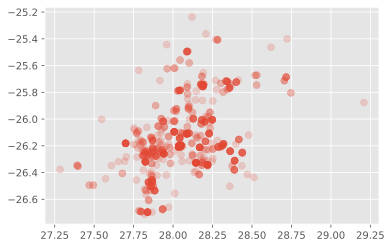

In [59]:
plt.scatter(X[:,0],X[:,1],alpha=0.2,s=50);

# Task 2: Visualizing Geographical Data

In [75]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
for _,row in df.iterrows():
    folium.CircleMarker(
        location = [row.LAT, row.LON],
        radius = 5,
        popup = re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color = '#1787FE',
        fill=True,
        fillcolor='#1787FE'        
    ).add_to(m)

In [76]:
# = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
m

# Task 3: Clustering Strength / Performance Metric

In [78]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, cluster_std=0.5, random_state=4)

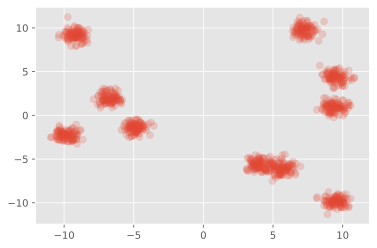

In [79]:
plt.scatter(X_blobs[:,0],X_blobs[:,1],alpha=0.2,s=50);

In [83]:
class_predictions = np.array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2,
       2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 1, 2, 2, 1, 0, 0,
       0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 2, 1, 1, 0, 2,
       0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0,
       2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0,
       1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 1, 1, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0,
       0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 0,
       2, 0, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 1,
       0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2,
       0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 0, 1, 1,
       1, 0, 2, 1, 2, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 1,
       2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 1,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2,
       0, 1, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0,
       0, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2,
       0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2,
       2, 0, 2, 1, 0, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 2,
       1, 1, 2, 2, 0, 2, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 0,
       1, 0, 0, 2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1,
       0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1,
       0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0,
       2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 0,
       1, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0,
       0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 0, 0, 2,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2,
       2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0,1, 2, 0, 2, 0, 1, 0, 1, 1, 2])

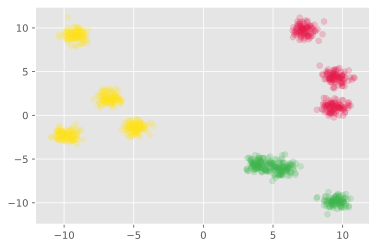

In [90]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c=cols[unique_cluster]);

In [92]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

In [95]:
class_predictions_improved = np.array([1, 6, 7, 7, 4, 3, 2, 3, 5, 4, 6, 2, 5, 0, 1, 9, 2, 2, 9, 9, 6, 0,
       7, 8, 1, 9, 5, 3, 8, 2, 1, 2, 0, 7, 8, 5, 7, 2, 9, 8, 8, 5, 7, 5,
       6, 2, 7, 9, 3, 6, 4, 7, 4, 2, 9, 6, 5, 1, 6, 7, 0, 0, 6, 7, 4, 3,
       7, 6, 8, 4, 5, 5, 3, 7, 6, 1, 3, 8, 9, 5, 9, 7, 8, 1, 1, 4, 5, 7,
       4, 7, 7, 8, 1, 2, 5, 7, 2, 3, 6, 6, 7, 8, 4, 8, 2, 6, 8, 8, 7, 1,
       0, 5, 0, 2, 7, 2, 2, 9, 2, 6, 2, 4, 3, 5, 8, 2, 2, 6, 4, 7, 8, 8,
       7, 0, 4, 4, 3, 6, 3, 3, 8, 8, 1, 9, 0, 6, 6, 7, 7, 3, 3, 1, 0, 5,
       2, 3, 0, 8, 0, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 6, 1, 3, 7, 8, 1,
       6, 8, 4, 1, 4, 2, 6, 3, 2, 4, 5, 2, 6, 0, 6, 9, 3, 6, 1, 5, 3, 5,
       4, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 0, 2, 1, 7, 9, 2, 6, 6, 0, 1, 0,
       1, 4, 0, 7, 8, 7, 4, 0, 8, 0, 6, 7, 7, 2, 5, 4, 8, 0, 4, 3, 1, 4,
       4, 7, 8, 5, 3, 6, 1, 4, 8, 0, 0, 4, 9, 1, 4, 2, 8, 0, 9, 3, 6, 5,
       4, 0, 6, 2, 3, 0, 1, 2, 5, 9, 8, 0, 7, 1, 7, 0, 9, 0, 4, 0, 7, 9,
       3, 4, 9, 8, 2, 0, 9, 5, 5, 6, 3, 3, 2, 1, 3, 3, 4, 3, 5, 5, 1, 6,
       1, 9, 7, 9, 3, 8, 4, 9, 4, 5, 2, 1, 6, 2, 4, 7, 3, 2, 7, 2, 1, 6,
       5, 8, 9, 6, 9, 9, 9, 1, 2, 7, 5, 8, 9, 0, 0, 6, 2, 7, 1, 9, 3, 8,
       8, 6, 4, 2, 0, 6, 0, 3, 0, 0, 4, 0, 3, 7, 8, 6, 3, 5, 9, 4, 3, 1,
       8, 9, 3, 1, 2, 1, 8, 2, 0, 6, 2, 4, 8, 8, 7, 6, 9, 9, 0, 8, 1, 3,
       1, 3, 2, 8, 1, 7, 3, 3, 7, 0, 9, 0, 6, 5, 9, 1, 3, 6, 6, 8, 8, 0,
       9, 5, 3, 2, 4, 7, 9, 5, 8, 5, 5, 3, 0, 4, 4, 0, 1, 1, 2, 9, 0, 4,
       5, 5, 7, 7, 9, 4, 6, 1, 3, 9, 8, 1, 3, 1, 3, 6, 9, 5, 0, 1, 8, 8,
       8, 9, 9, 5, 6, 1, 0, 4, 9, 7, 2, 4, 1, 7, 0, 2, 2, 1, 4, 7, 4, 0,
       5, 3, 0, 4, 0, 6, 1, 5, 6, 2, 2, 9, 2, 4, 5, 8, 2, 9, 5, 1, 9, 0,
       8, 5, 8, 8, 1, 0, 3, 3, 5, 4, 9, 9, 3, 3, 1, 0, 3, 5, 2, 5, 0, 4,
       0, 0, 2, 6, 1, 1, 5, 0, 0, 4, 7, 4, 7, 6, 4, 1, 5, 9, 6, 3, 3, 6,
       0, 8, 5, 7, 8, 3, 2, 8, 8, 5, 2, 9, 4, 5, 7, 8, 7, 1, 3, 3, 4, 4,
       2, 3, 1, 9, 5, 9, 9, 7, 3, 7, 9, 1, 4, 3, 6, 7, 9, 3, 8, 5, 5, 9,
       7, 0, 9, 2, 4, 8, 5, 3, 4, 4, 7, 2, 3, 4, 9, 0, 0, 3, 8, 3, 2, 7,
       6, 0, 6, 6, 0, 1, 1, 0, 6, 7, 8, 8, 4, 9, 1, 3, 3, 8, 4, 1, 6, 9,
       9, 7, 2, 6, 4, 4, 6, 6, 1, 7, 7, 2, 4, 2, 4, 9, 6, 3, 8, 1, 1, 6,
       5, 0, 1, 3, 5, 5, 0, 8, 3, 5, 2, 6, 6, 5, 3, 7, 6, 0, 0, 1, 8, 6,
       3, 9, 6, 6, 3, 2, 1, 4, 9, 6, 3, 5, 8, 7, 9, 7, 4, 8, 7, 8, 5, 8,
       3, 5, 5, 0, 2, 9, 4, 3, 6, 0, 6, 8, 1, 2, 0, 9, 9, 1, 7, 9, 1, 1,
       8, 8, 7, 5, 1, 6, 0, 0, 7, 8, 2, 4, 3, 3, 5, 4, 7, 4, 1, 9, 6, 2,
       7, 8, 2, 3, 1, 1, 4, 6, 8, 9, 0, 8, 7, 9, 5, 7, 9, 2, 8, 0, 6, 7,
       5, 8, 5, 9, 0, 5, 3, 4, 2, 7, 4, 6, 9, 6, 6, 6, 2, 2, 8, 1, 8, 6,
       9, 2, 6, 7, 8, 1, 3, 9, 4, 1, 4, 8, 9, 7, 1, 8, 6, 0, 2, 5, 6, 0,
       9, 8, 8, 5, 3, 9, 5, 7, 6, 3, 4, 4, 5, 7, 5, 3, 2, 8, 5, 4, 3, 2,
       0, 2, 4, 0, 6, 9, 9, 1, 1, 5, 0, 1, 0, 3, 8, 7, 0, 7, 9, 7, 5, 4,
       8, 4, 6, 1, 4, 7, 4, 3, 9, 5, 1, 1, 9, 3, 4, 0, 2, 2, 4, 6, 1, 8,
       5, 5, 1, 3, 6, 9, 0, 7, 5, 1, 7, 8, 8, 2, 4, 5, 9, 9, 3, 2, 7, 8,
       2, 7, 0, 0, 5, 6, 9, 7, 5, 2, 1, 9, 1, 5, 1, 4, 9, 9, 5, 6, 8, 8,
       3, 0, 4, 5, 8, 5, 7, 8, 6, 9, 9, 7, 3, 4, 2, 1, 0, 8, 9, 3, 8, 7,
       9, 2, 2, 2, 4, 6, 2, 7, 2, 4, 7, 7, 1, 6, 1, 3, 3, 8, 4, 5, 4, 7,
       1, 9, 9, 5, 3, 1, 0, 0, 5, 3, 5, 9, 1, 1, 6, 6, 0, 5, 6, 1, 3, 0,
       4, 1, 0, 7, 0, 2, 0, 4, 2, 6])

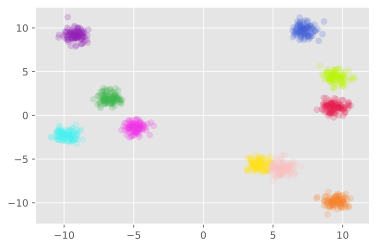

In [100]:
unique_clusters = np.unique(class_predictions_improved)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions_improved==unique_cluster]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c=cols[unique_cluster]);

In [101]:
silhouette_score(X_blobs, class_predictions_improved)

0.7473587799908298

# Task 4: K-Means Clustering


In [103]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 

                        n_features=2, cluster_std=1, random_state=4)

In [104]:
data = defaultdict(dict)

for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [105]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [110]:
X = np.array(df[['LON','LAT']],dtype='float64')

In [113]:
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans {k}'] = class_predictions

In [114]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70  \
0  28.17858 -25.73882         11th Street Taxi Rank                15   
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15   
2  27.83239 -26.53722          Adams Road Taxi Rank                 5   
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33   
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18   

   CLUSTER_kmeans 70  
0                 15  
1                 15  
2                  5  
3                 33  
4                 18

In [118]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():
        
        # get a colour
        cluster_colour = cols[row[cluster_column]]
        
        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    
    return m    
m = create_map(df, 'CLUSTER_kmeans 70')

print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948588169


In [119]:
m

In [120]:
best_silhouette, best_k = -1, 0


for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)    

    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette        

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████████████████████████████████████| 98/98 [01:29<00:00,  1.10it/s]

K=98
Silhouette Score: 0.6971995093259049


# Task 5: DBSCAN

In [123]:
# Density-Based Spatial Clustering of Applications with Noise

# code for indexing out certain values

dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
new = np.array([(counter+2)*x if x==-1  else x for counter, x in enumerate(dummy)])

In [124]:
new

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [126]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTER_DBSCAN'] = class_predictions

In [131]:
m = create_map(df, 'CLUSTER_DBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')


print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138245464832
Silhouette outliers as singletons: 0.5667489347788776


In [129]:
m

# Task 6: HDBSCAN

## Hierarchical DBSCAN

In [133]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [135]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')


print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])

print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')
m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504353546712
Silhouette outliers as singletons: 0.6389924830256725


# Task 7: Addressing Outliers

In [139]:
classifier = KNeighborsClassifier(n_neighbors=1, )

In [136]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [145]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON','LAT']], dtype='float64')

In [146]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [147]:
predictions = classifier.predict(X_predict)

In [148]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [149]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [152]:
m = create_map(df, 'CLUSTER_hybrid')

In [153]:
m

In [155]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')
m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126491937117


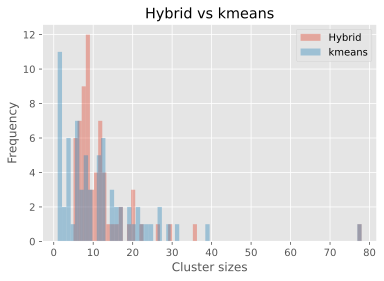

In [165]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4, label='kmeans')
plt.legend()
plt.title('Hybrid vs kmeans')
plt.xlabel('Cluster sizes');

In [162]:
df.columns

Index(['LON', 'LAT', 'NAME', 'CLUSTER_kmeans70', 'CLUSTER_kmeans 70',
       'CLUSTER_DBSCAN', 'CLUSTER_HDBSCAN', 'CLUSTER_hybrid'],
      dtype='object')